# League of Legends Recommender System

## Summary

### League of Legends is an online, 5 vs. 5 competitive PC game. It is one of the - if not the most - popular games currently around. Despite that LoL has surprisingly little mainstream coverage, which is most likely due to its complexity - it’s not an easy game to understand. A lot of professional leagues and tournaments for LoL are held around the world. The top prize for the best team is over five million dollars and the average player makes a six-figure income. The question is can we develop a data-driven recommender system using historical game data which can support players to make better decisions?

## Project Tasks 
### 1. Understand League of Legends 

* League of legends is a team oriented strategy game. The goal is to work together with your team-mates to bring down the enemy nexus located at the middle of their base before your opponents take down yours.
* Players start by choosing one champion from a list of many. All of them have their own unique strengths and personalities. There are types of champions like ranged, melee or arcane mages depending on the players style of play.
* During the game, champions get stronger in two ways. The first of which is leveling up. Players gain experience by being in the area where the enemy dies and each level unlocks abilities of the champions. At level 6, players can unlock ultimate ability which can change the tide of the game. The second way to get stronger is to buy items using gold obtained by killing enemies in a match. Items bought go to inventory which can be used in the game. There are a wide variety of items and they complement a champion in their own way. When a payer starts the game, the team appears in the fountain and its a safe place to respawn which provides access to the shop.
* Each player starts the game with some gold with which they can buy items to be used in the match. Items can also be upgraded. There are 3 lanes in the game where the players head to (Top, Mid(Middle), Bot(Bottom)). The forest in-between the players also has monsters and killing them provides gold, experiences and buffs. The bases are guarded by powerful touretts which need to be destroyed to get to the enemies nexus.
* The player that destroys the opponents nexus is declared the winner.

### 2. Fetch in-game data using Riot API/Kaggle datasets 

The dataset is obtained from https://www.kaggle.com/datasets/datasnaek/league-of-legends?select=games.csv
It contains 3 json files and 1 csv file as described below:
1. champion_info.json - A JSON file containing the details of champions such as their title, id, key and name.
2. champion_info_2.json - A JSON file containing similar details as champion_info.json with an additional field tags, which contains the tag associated with the champion.
3. summoner_spell_info.json - A JSON file containing the details of spells available in the game such as id, summonerLevel, name, key and description.
4. games.csv - A CSV file containing the following game data:
    * Game ID
    * Creation Time (in Epoch format)
    * Game Duration (in seconds)
    * Season ID
    * Winner (1 = team1, 2 = team2)
    * First Baron, dragon, tower, blood, inhibitor and Rift Herald (1 = team1, 2 = team2, 0 = none)
    * Champions and summoner spells for each team (Stored as Riot's champion and summoner spell IDs)
    * The number of tower, inhibitor, Baron, dragon and Rift Herald kills each team has
    * The 5 bans of each team (Again, champion IDs are used)

In [1]:
# Importing the neccessary packages and setting display options

import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# set up display area to show dataframe in jupyter qtconsole

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Reading the data into relavent data structures

chmp_info_fp = open('champion_info_2.json')
champion_dict = json.load(chmp_info_fp)["data"]

# Printing one random record(key) for ease of understanding
print("Sample Champion info: ", champion_dict["MonkeyKing"])

summ_spell_info = open('summoner_spell_info.json')
spells_dict = json.load(summ_spell_info)["data"]

# Printing one random record(key) for ease of understanding
print("Sample Spell info: ", spells_dict["3"])

Sample Champion info:  {'tags': ['Fighter', 'Tank'], 'title': 'the Monkey King', 'id': 62, 'key': 'MonkeyKing', 'name': 'Wukong'}
Sample Spell info:  {'id': 3, 'summonerLevel': 4, 'name': 'Exhaust', 'key': 'SummonerExhaust', 'description': 'Exhausts target enemy champion, reducing their Movement Speed by 30%, and their damage dealt by 40% for 2.5 seconds.'}


### 3. Structure the dataset in columnar format 

In [3]:
# Reading the csv as a dataframe in pandas
games_df = pd.read_csv("games.csv")
# Displaying first 5 records from the csv
games_df.head(5)

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,t1_champ4id,t1_champ4_sum1,t1_champ4_sum2,t1_champ5id,t1_champ5_sum1,t1_champ5_sum2,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_champ1id,t2_champ1_sum1,t2_champ1_sum2,t2_champ2id,t2_champ2_sum1,t2_champ2_sum2,t2_champ3id,t2_champ3_sum1,t2_champ3_sum2,t2_champ4id,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,2,8,12,4,432,3,4,96,4,7,11,11,6,112,4,14,11,1,2,3,0,92,40,69,119,141,104,11,4,498,4,7,122,6,4,238,14,4,412,4,3,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,1,119,7,4,39,12,4,76,4,3,10,4,14,35,4,11,10,4,0,2,1,51,122,17,498,19,54,4,12,25,4,14,120,11,4,157,4,14,92,4,7,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,0,18,4,7,141,11,4,267,3,4,68,4,12,38,12,4,8,1,1,1,0,117,40,29,16,53,69,4,7,412,14,4,126,4,12,24,4,11,22,7,4,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,0,57,4,12,63,4,14,29,4,7,61,4,1,36,11,4,9,2,1,2,0,238,67,516,114,31,90,14,4,19,11,4,412,4,3,92,4,14,22,4,7,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,0,19,4,12,29,11,4,40,4,3,119,4,7,134,7,4,9,2,1,3,0,90,64,412,25,31,37,3,4,59,4,12,141,11,4,38,4,12,51,4,7,3,0,0,1,0,86,11,201,122,18


In [4]:
# Understanding the data
print(f"The dataframe has {games_df.shape[0]} rows and {games_df.shape[1]} columns")
print(f"The list of columns is : {games_df.columns}")
print(f"The type of data present in the dataframe : {games_df.dtypes}")

The dataframe has 51490 rows and 61 columns
The list of columns is : Index(['gameId', 'creationTime', 'gameDuration', 'seasonId', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills', 't2_ban1', 

In [5]:
# Checking for missing values in the data
games_df.isna().sum().sum()

0

There are no missing values anywhere in the data

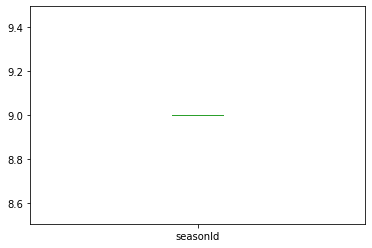

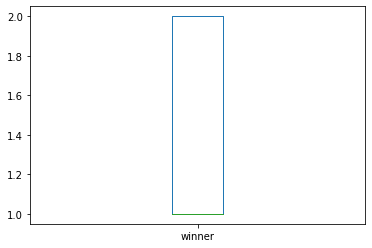

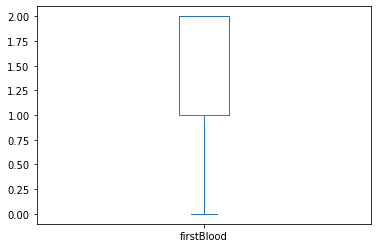

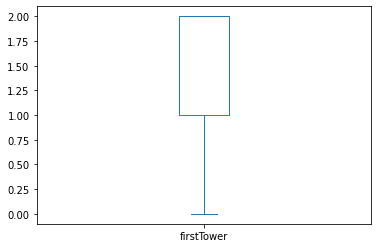

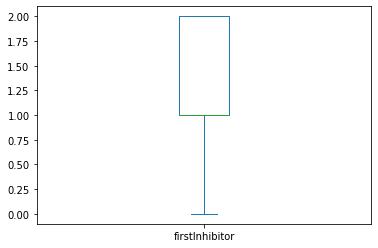

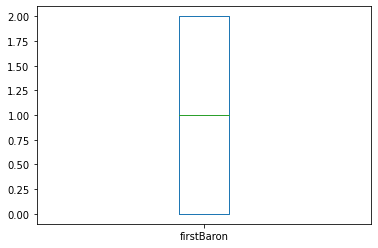

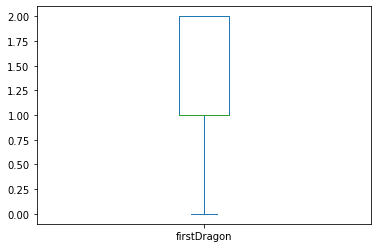

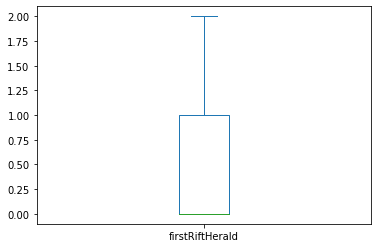

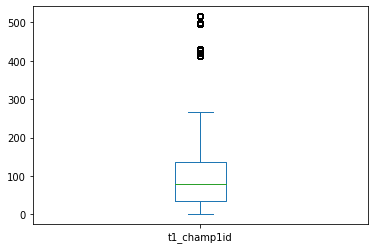

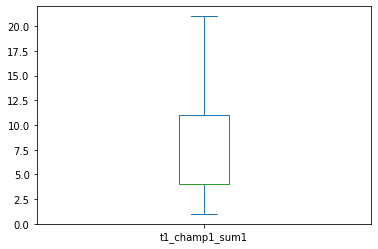

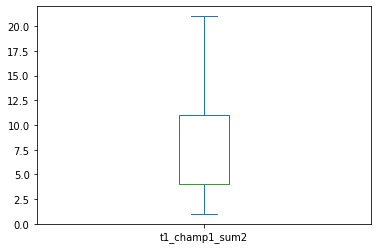

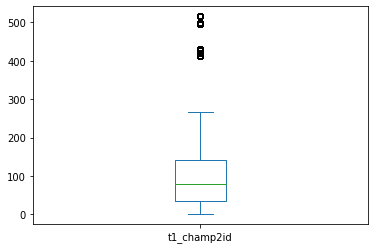

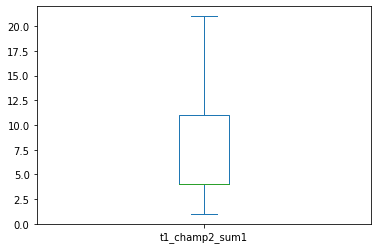

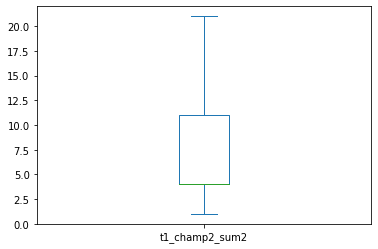

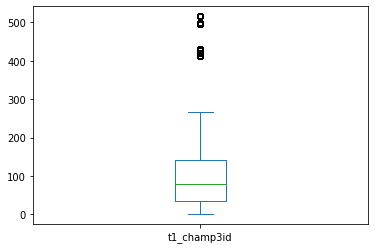

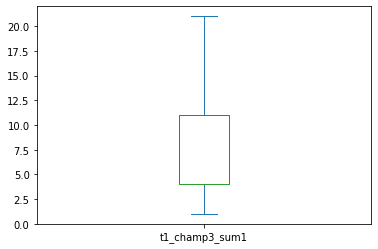

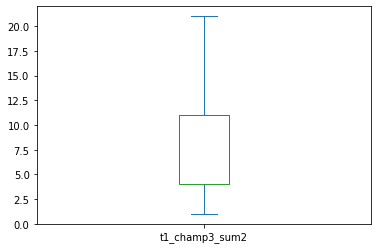

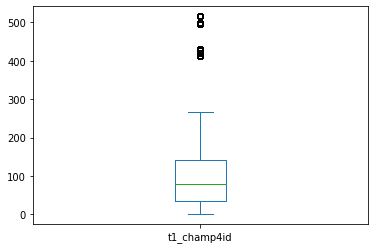

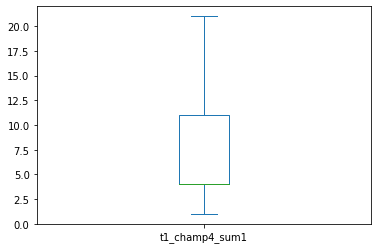

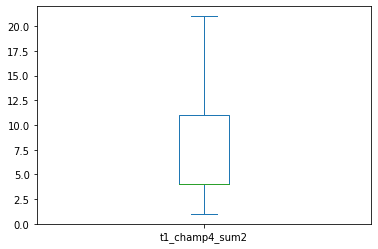

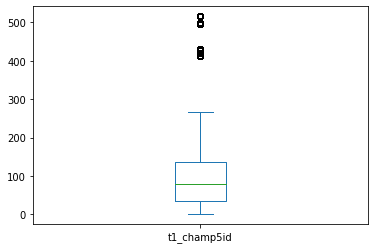

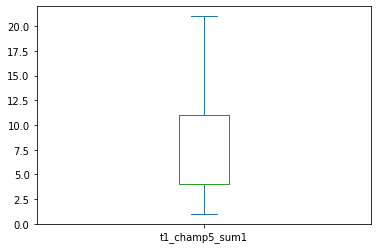

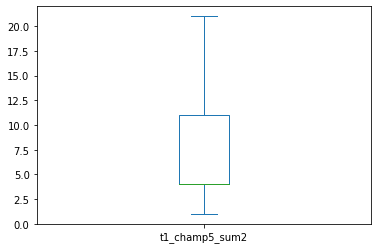

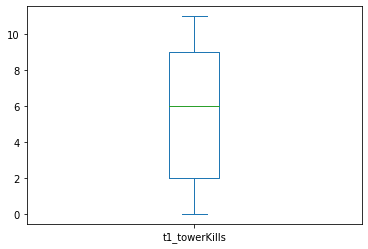

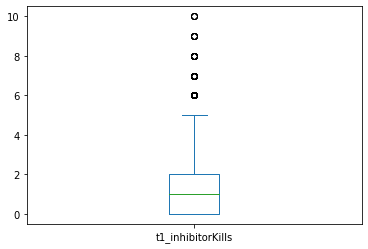

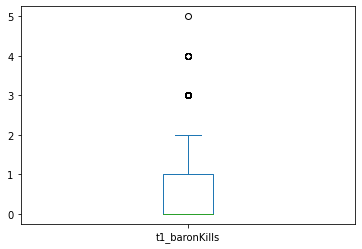

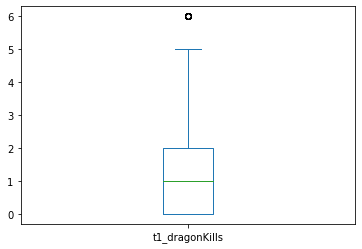

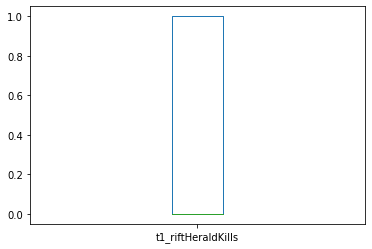

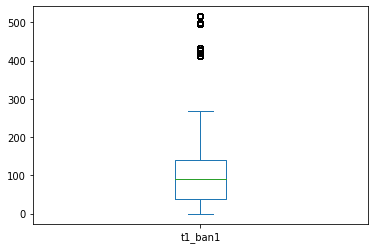

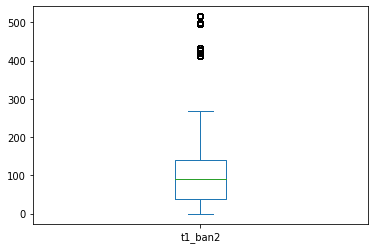

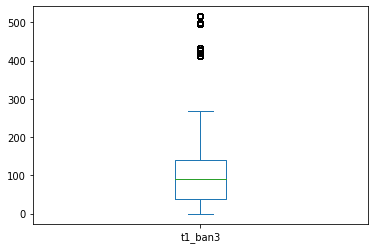

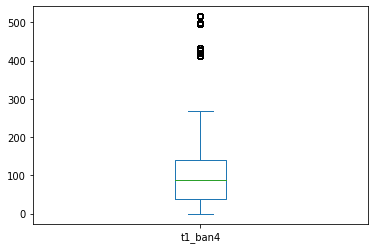

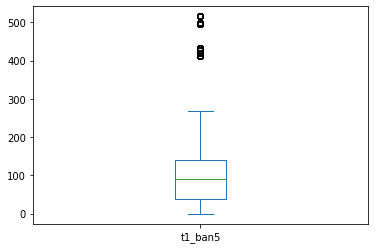

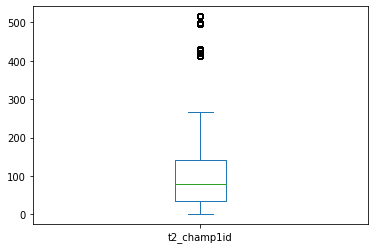

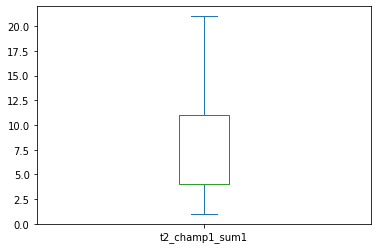

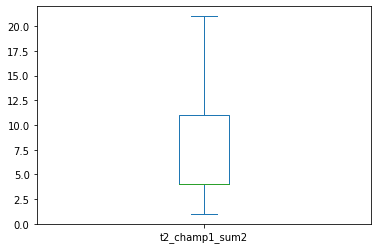

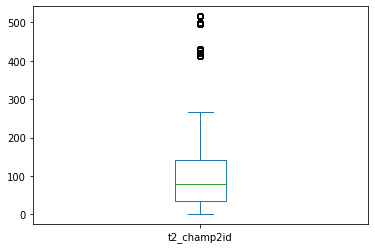

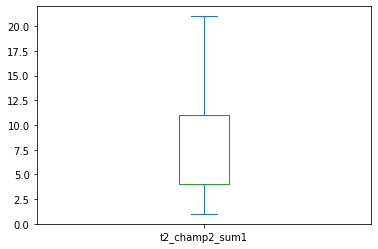

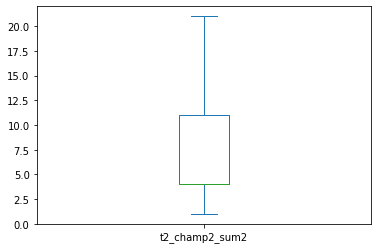

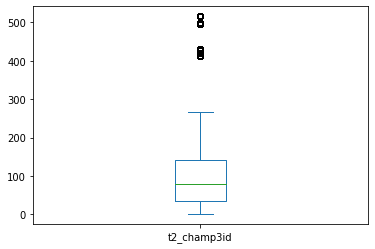

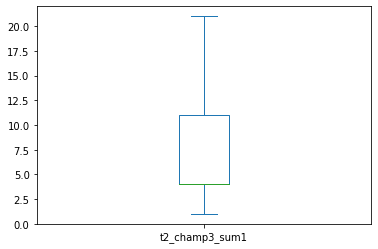

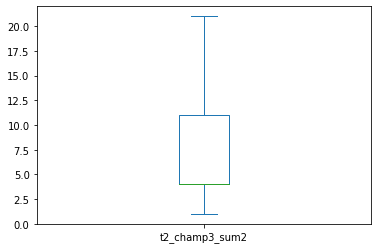

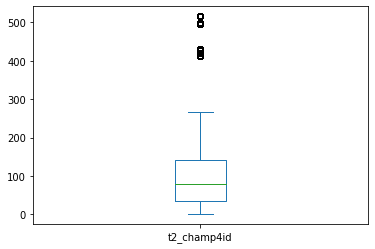

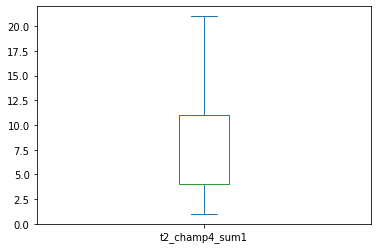

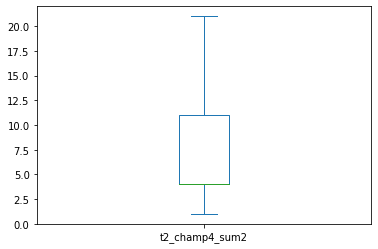

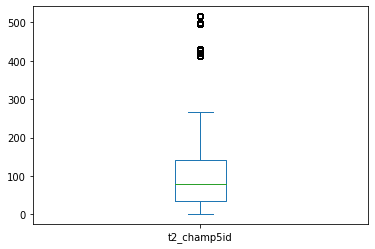

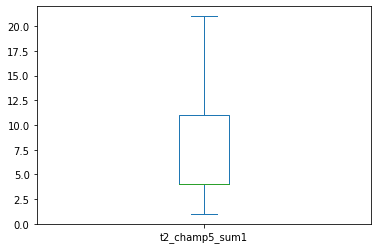

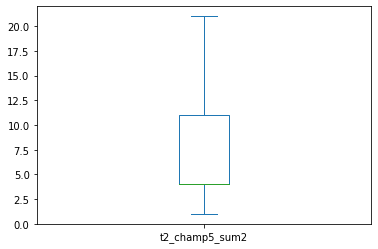

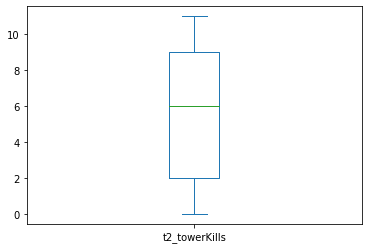

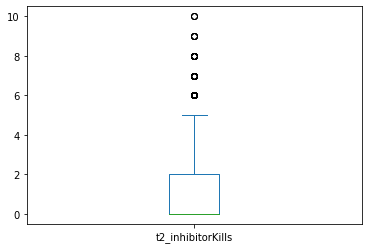

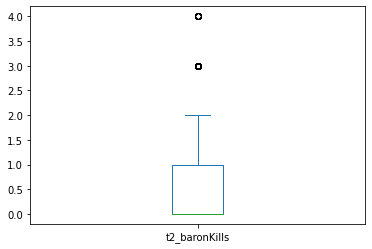

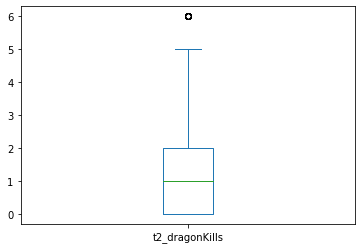

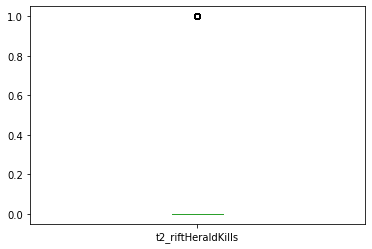

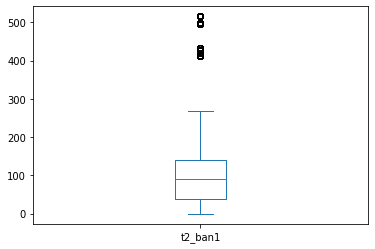

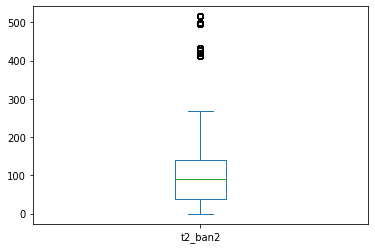

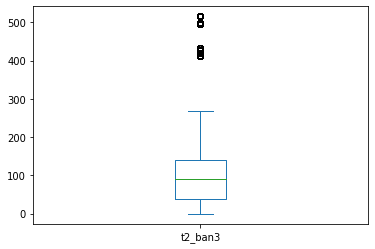

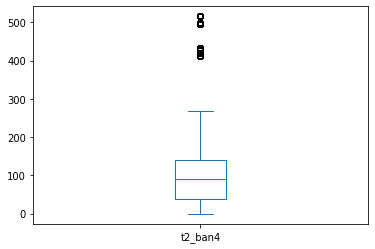

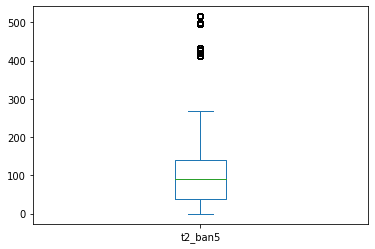

In [6]:
for column in games_df.columns[3:]:
    games_df[[column]].plot(kind='box')
    plt.show()
    

The data does not seem to have any anomolous values in it that will falter an algorithm in any way.

### 4. Define recommender system elements and approach towards recommendation

For our analysis, we are considering games which have been played between 2 players in a PVP setting. The recommendation system is a collaborative filtering recommendation system as it makes recommendation based on user interactions. It esentially takes the interactions and learns the factors within them to best generaize these interactions. Collaborative filtering requires no domain knowledge,  the data generated by itself such as user interactions is enough to harvest other favourable user interactions for recommending and targeting. Some systems will have multiple layers of user interactions which can be taken advantage of.

The expectation is that there are combinations of champions and items that get the player to victory by defining the actions to be taken next. The actions themselves are actions that other players have taken that lead to victory. The recommendation system itself is a machine learning algorithm that finds the best path to victory given a combination of choices that a player takes throughout the game.

The approach towards recommendation is as follows:
* Import Data - Import the data into the environment by using python libraries.
* Data processing - Data processing involves cleaning the data by identifying any null values, removing anomolous data, data type formatting, normalization, etc.
* Correlinearity - Find the correlations between the target(win) and all the independent variables to understand the features which help make decisions the best.
* Visualization - Plot the variables in a variety of plots to show the characteristics of values they represent.
* Preprocessing - Data preprocessing is more concentrated towards making sure all the features are ready to be used by the model and also provide as much information as possible to solve the problem.
* Modelling - Use different algorithms, comparing them against each other or combine them together to predict the victorious outcome for a given game.
* Postprocessing - Cleaning the output received from the winner model and coming to a conclusion of what action needs to be taken for victory.

### 5. Perform basic statistical tests 

In [7]:
# Understanding the distribution of values in the data
games_df.describe()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,t1_champ4id,t1_champ4_sum1,t1_champ4_sum2,t1_champ5id,t1_champ5_sum1,t1_champ5_sum2,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_champ1id,t2_champ1_sum1,t2_champ1_sum2,t2_champ2id,t2_champ2_sum1,t2_champ2_sum2,t2_champ3id,t2_champ3_sum1,t2_champ3_sum2,t2_champ4id,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
count,5.149000e+04,5.149000e+04,51490.000000,51490.0,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000,51490.000000
mean,3.306223e+09,1.502926e+12,1832.362808,9.0,1.493552,1.471295,1.450631,1.308487,0.926510,1.442804,0.731676,114.293397,6.601787,7.333929,118.101631,6.547796,7.198213,116.905127,6.542280,7.200602,117.657953,6.530511,7.221441,114.601748,6.622412,7.261235,5.699359,1.017537,0.372286,1.387182,0.251466,108.319713,108.786094,108.205904,107.630491,109.027287,115.852088,6.595261,7.305457,117.580618,6.546630,7.230627,117.481103,6.521849,7.227384,118.185881,6.535424,7.201476,115.941853,6.612682,7.249680,5.549466,0.985084,0.414547,1.404370,0.240105,108.216294,107.910216,108.690581,108.626044,108.066576
std,2.946096e+07,1.978026e+09,512.017696,0.0,0.499963,0.520326,0.542848,0.676097,0.841424,0.569579,0.822526,119.000867,4.025601,4.299902,123.577538,3.980675,4.224076,122.653184,3.966289,4.243279,123.354082,3.965559,4.244099,120.042622,4.020005,4.257531,3.799808,1.263934,0.583934,1.206818,0.433860,102.247492,102.942617,102.660955,103.000610,102.433377,121.694131,4.028611,4.280467,123.297642,3.976676,4.256462,122.939051,3.960422,4.242333,124.002327,3.963142,4.235044,122.015086,4.013472,4.253408,3.860989,1.256284,0.613768,1.224492,0.427151,102.551787,102.870710,102.592145,103.346952,102.756149
min,3.214824e+09,1.496892e+12,190.000000,9.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,3.292218e+09,1.502021e+12,1531.000000,9.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,35.000000,4.000000,4.000000,35.000000,4.000000,4.000000,35.000000,4.000000,4.000000,36.000000,4.000000,4.000000,35.000000,4.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,38.000000,38.000000,37.000000,38.000000,38.000000,35.000000,4.000000,4.000000,35.000000,4.000000,4.000000,36.000000,4.000000,4.000000,35.000000,4.000000,4.000000,35.000000,4.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,38.000000,37.000000,38.000000,38.000000,38.000000
50%,3.320021e+09,1.503844e+12,1833.000000,9.0,1.000000,1.000000,1.000000,1.

gameId skewness: -1.3923463149780027
gameId kurtosis: 0.8305221343815115


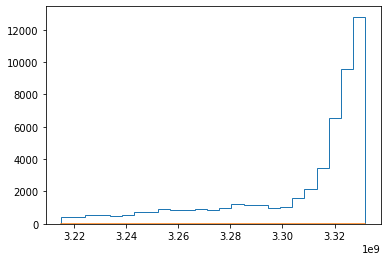



creationTime skewness: -1.3593309467607437
creationTime kurtosis: 0.7135212578923991


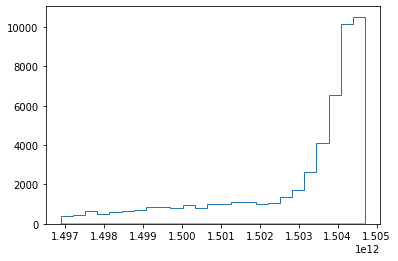



gameDuration skewness: -0.30837893024888846
gameDuration kurtosis: 1.4873764404751961


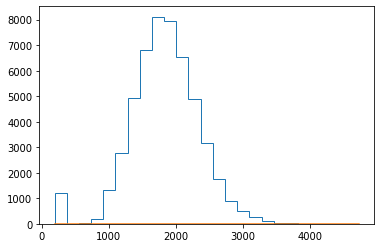



seasonId skewness: 0
seasonId kurtosis: 0


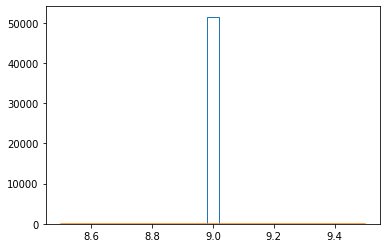



winner skewness: 0.025794312066012678
winner kurtosis: -1.9994123171341773


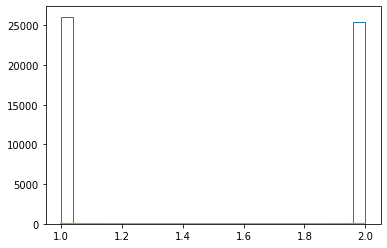



firstBlood skewness: -0.1148266954435193
firstBlood kurtosis: -1.4556487943402856


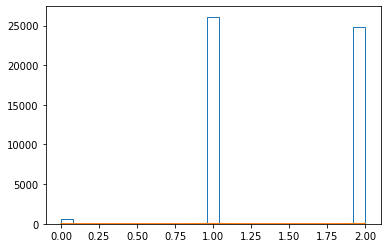



firstTower skewness: -0.24538684853837928
firstTower kurtosis: -1.0627224200599823


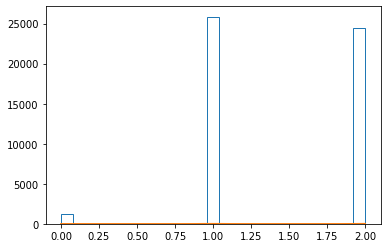



firstInhibitor skewness: -0.46563848424436766
firstInhibitor kurtosis: -0.7994572036380698


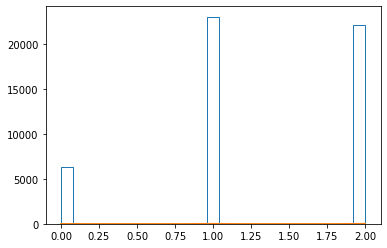



firstBaron skewness: 0.13932675485785417
firstBaron kurtosis: -1.5739475363448578


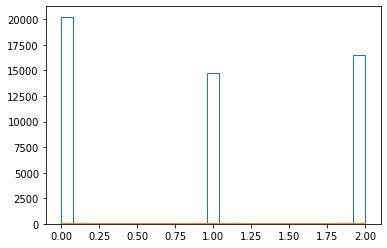



firstDragon skewness: -0.4057661138623568
firstDragon kurtosis: -0.7843376281345908


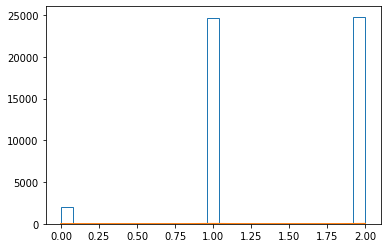



firstRiftHerald skewness: 0.5312046870470795
firstRiftHerald kurtosis: -1.3212995010572515


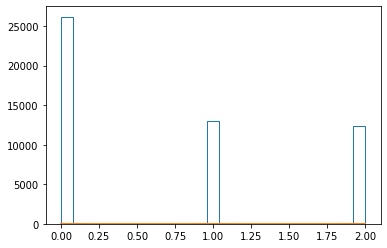



t1_champ1id skewness: 1.8786674647949952
t1_champ1id kurtosis: 3.065643136981807


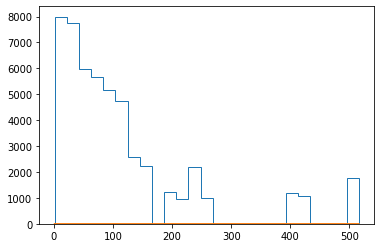



t1_champ1_sum1 skewness: 1.229715803074866
t1_champ1_sum1 kurtosis: 0.6725269400184772


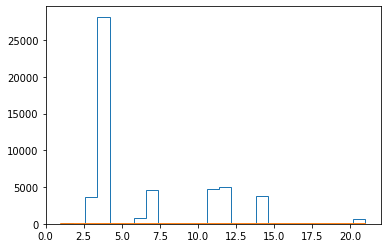



t1_champ1_sum2 skewness: 0.8567792992283331
t1_champ1_sum2 kurtosis: -0.159856404917734


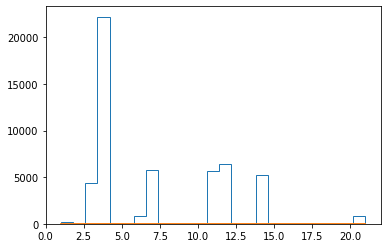



t1_champ2id skewness: 1.7959248388680775
t1_champ2id kurtosis: 2.5861184512926227


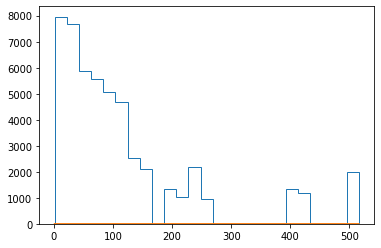



t1_champ2_sum1 skewness: 1.2457221056544936
t1_champ2_sum1 kurtosis: 0.71262700132083


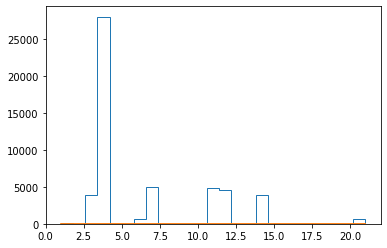



t1_champ2_sum2 skewness: 0.9120246828556566
t1_champ2_sum2 kurtosis: -0.04594768711489783


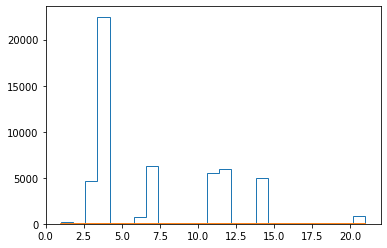



t1_champ3id skewness: 1.8188359239835374
t1_champ3id kurtosis: 2.6972660368662567


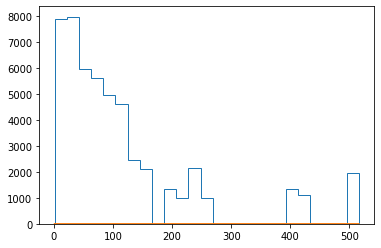



t1_champ3_sum1 skewness: 1.2354198439651645
t1_champ3_sum1 kurtosis: 0.6687749646742591


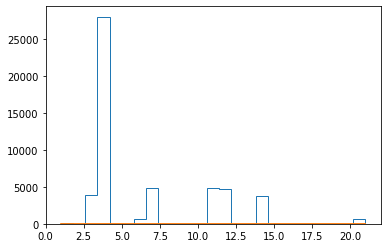



t1_champ3_sum2 skewness: 0.9192100349947894
t1_champ3_sum2 kurtosis: -0.018727816202591452


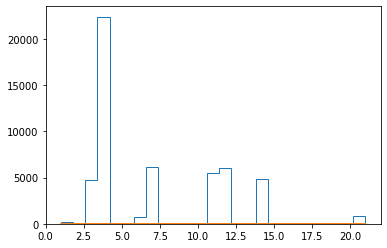



t1_champ4id skewness: 1.8137004752288601
t1_champ4id kurtosis: 2.644669104506444


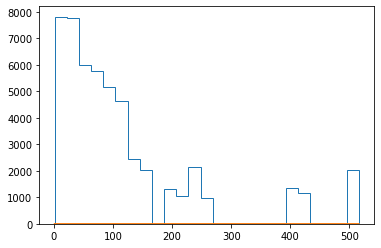



t1_champ4_sum1 skewness: 1.2488382593621605
t1_champ4_sum1 kurtosis: 0.7148885750942471


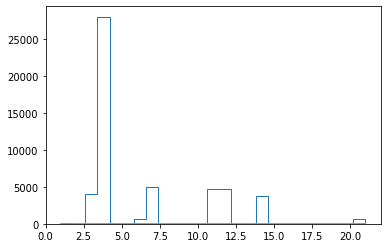



t1_champ4_sum2 skewness: 0.9028689798179319
t1_champ4_sum2 kurtosis: -0.06856168238733451


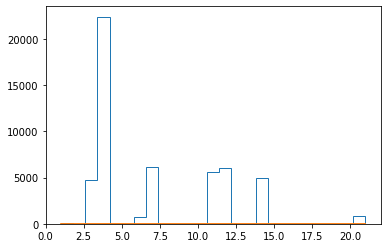



t1_champ5id skewness: 1.8619526560862063
t1_champ5id kurtosis: 2.9372999656910785


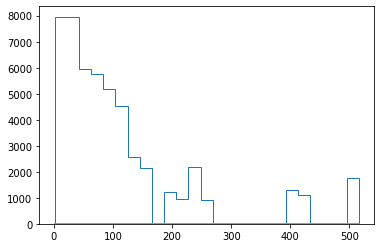



t1_champ5_sum1 skewness: 1.1910419375856331
t1_champ5_sum1 kurtosis: 0.5245722076269321


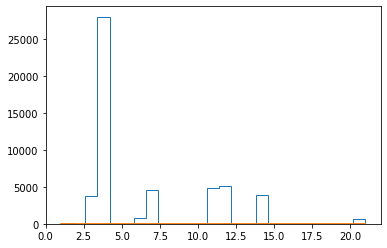



t1_champ5_sum2 skewness: 0.8692090327091871
t1_champ5_sum2 kurtosis: -0.15811645078225967


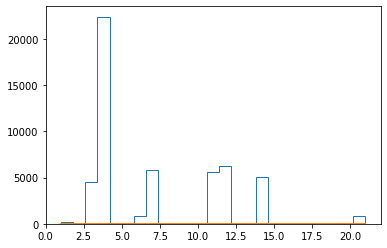



t1_towerKills skewness: -0.09361551140011572
t1_towerKills kurtosis: -1.43246223487447


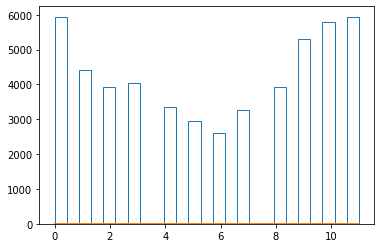



t1_inhibitorKills skewness: 1.2087709787032372
t1_inhibitorKills kurtosis: 1.2808602581806596


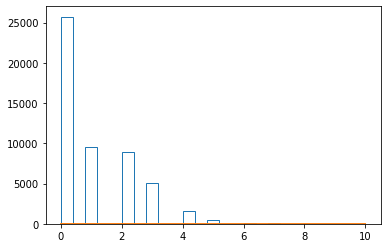



t1_baronKills skewness: 1.4286614211230073
t1_baronKills kurtosis: 1.6432258698474262


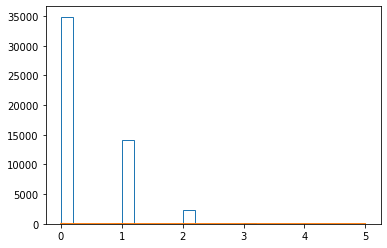



t1_dragonKills skewness: 0.5564306986621625
t1_dragonKills kurtosis: -0.40579256429431165


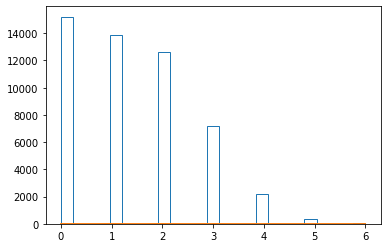



t1_riftHeraldKills skewness: 1.1457301686355714
t1_riftHeraldKills kurtosis: -0.6873290797625367


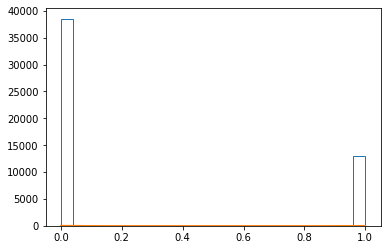



t1_ban1 skewness: 2.1428125776040097
t1_ban1 kurtosis: 5.328370834938451


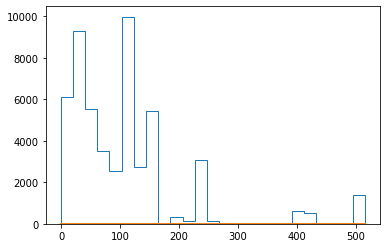



t1_ban2 skewness: 2.118211267779232
t1_ban2 kurtosis: 5.18227873355382


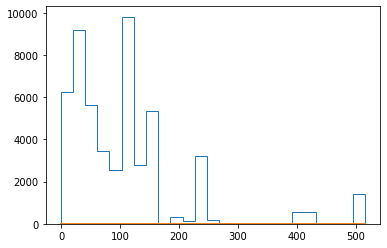



t1_ban3 skewness: 2.123723027297845
t1_ban3 kurtosis: 5.188738028232611


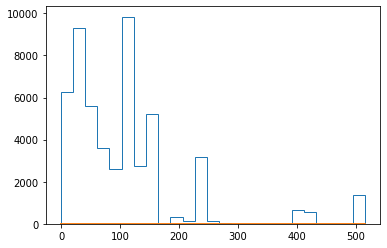



t1_ban4 skewness: 2.1748822527974156
t1_ban4 kurtosis: 5.419868552918325


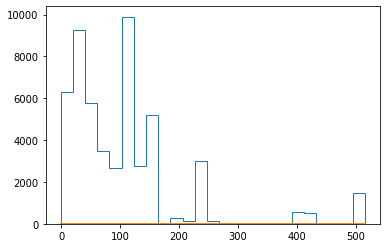



t1_ban5 skewness: 2.12351675621684
t1_ban5 kurtosis: 5.216487729140998


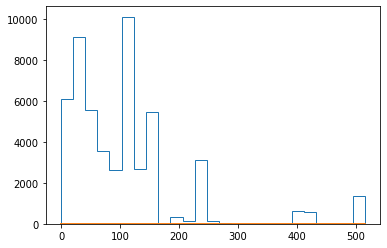



t2_champ1id skewness: 1.8503885639796975
t2_champ1id kurtosis: 2.8461720626211733


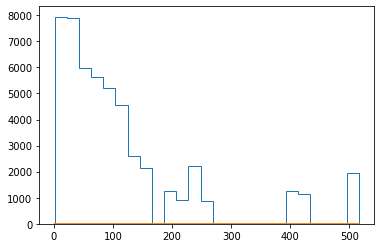



t2_champ1_sum1 skewness: 1.2237287129417571
t2_champ1_sum1 kurtosis: 0.6267044409880786


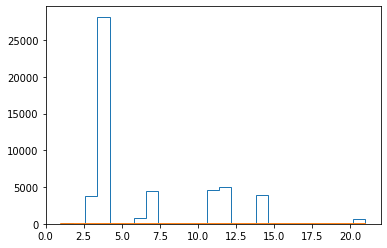



t2_champ1_sum2 skewness: 0.8698915591686599
t2_champ1_sum2 kurtosis: -0.12164979213324534


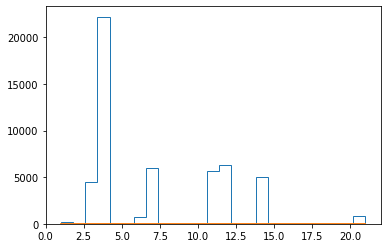



t2_champ2id skewness: 1.8106457847746984
t2_champ2id kurtosis: 2.638711044574098


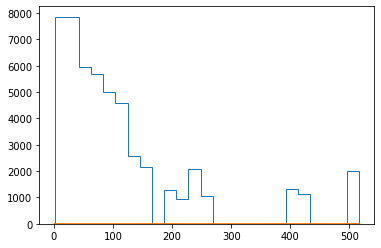



t2_champ2_sum1 skewness: 1.2422755322668875
t2_champ2_sum1 kurtosis: 0.6901133270845934


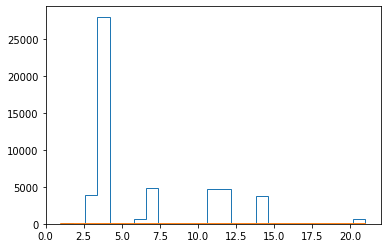



t2_champ2_sum2 skewness: 0.9171702725210502
t2_champ2_sum2 kurtosis: -0.00894733340337428


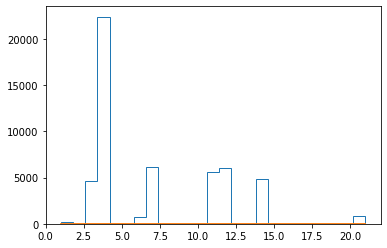



t2_champ3id skewness: 1.812775308519518
t2_champ3id kurtosis: 2.6550158920038447


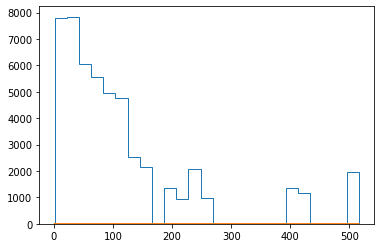



t2_champ3_sum1 skewness: 1.2481033932333723
t2_champ3_sum1 kurtosis: 0.6993528610307718


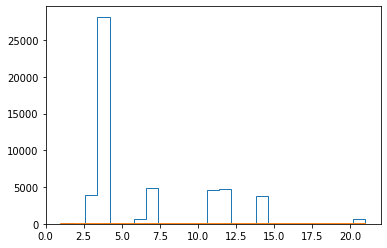



t2_champ3_sum2 skewness: 0.8924121397415823
t2_champ3_sum2 kurtosis: -0.0880049991081977


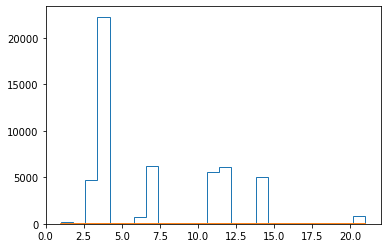



t2_champ4id skewness: 1.8010789710766877
t2_champ4id kurtosis: 2.5912310211513354


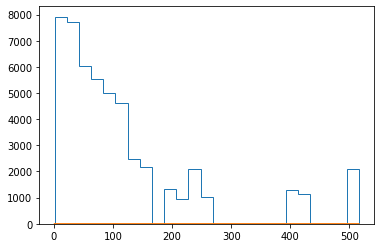



t2_champ4_sum1 skewness: 1.2459014570904858
t2_champ4_sum1 kurtosis: 0.7181161013148807


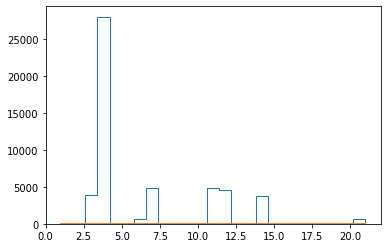



t2_champ4_sum2 skewness: 0.9142710635679336
t2_champ4_sum2 kurtosis: -0.027269738672024868


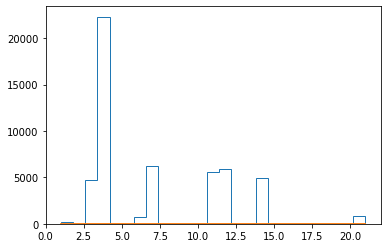



t2_champ5id skewness: 1.8427247934263622
t2_champ5id kurtosis: 2.802020165884877


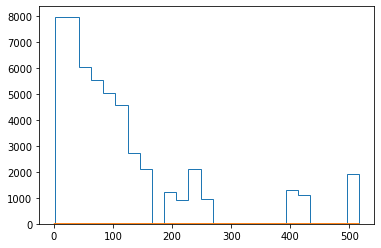



t2_champ5_sum1 skewness: 1.1834544458212897
t2_champ5_sum1 kurtosis: 0.4935624463088142


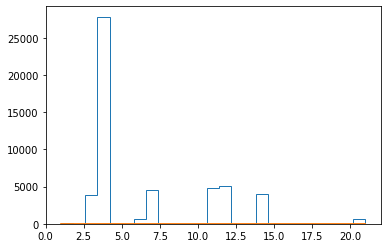



t2_champ5_sum2 skewness: 0.8693533606357495
t2_champ5_sum2 kurtosis: -0.1636757679370544


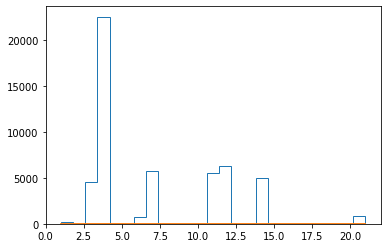



t2_towerKills skewness: -0.043917317320388775
t2_towerKills kurtosis: -1.473553860677238


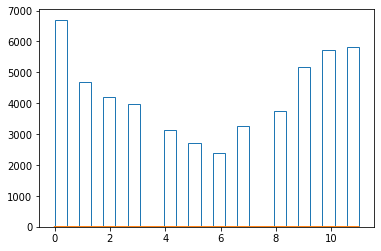



t2_inhibitorKills skewness: 1.2682422459207694
t2_inhibitorKills kurtosis: 1.476276415661422


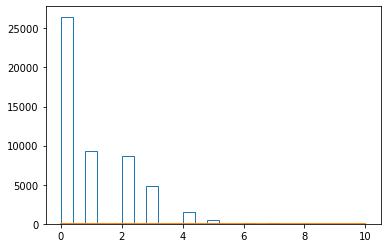



t2_baronKills skewness: 1.3304740700440334
t2_baronKills kurtosis: 1.3454652837035326


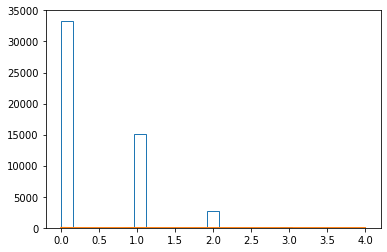



t2_dragonKills skewness: 0.5352474163599288
t2_dragonKills kurtosis: -0.47996529539584243


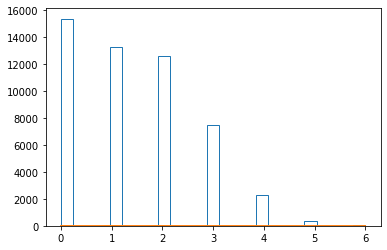



t2_riftHeraldKills skewness: 1.2169240202557052
t2_riftHeraldKills kurtosis: -0.5191160941970896


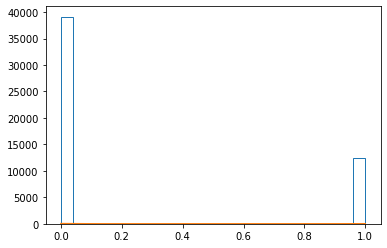



t2_ban1 skewness: 2.1370297587967335
t2_ban1 kurtosis: 5.281037423425254


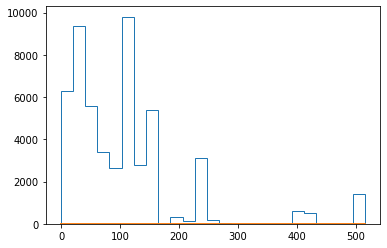



t2_ban2 skewness: 2.1532083831214637
t2_ban2 kurtosis: 5.339723128488919


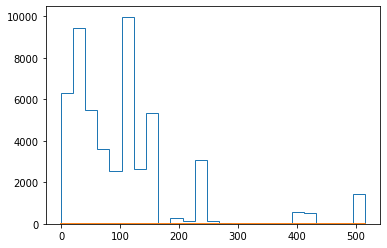



t2_ban3 skewness: 2.1417505796766303
t2_ban3 kurtosis: 5.297878487924588


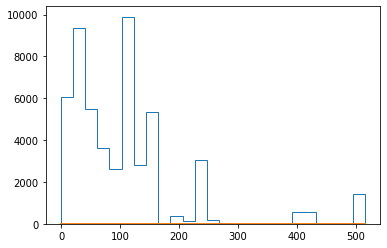



t2_ban4 skewness: 2.1415324185152618
t2_ban4 kurtosis: 5.226296525516546


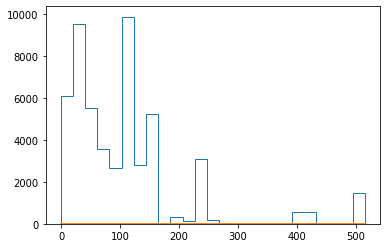



t2_ban5 skewness: 2.1454648063302044
t2_ban5 kurtosis: 5.3044572746624175


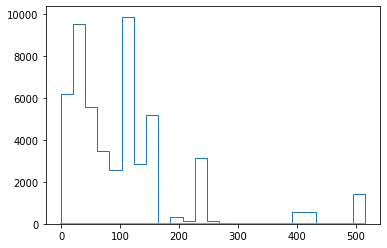

In [8]:
numeric_cols = games_df._get_numeric_data().columns
for num_col in numeric_cols:
    print(games_df[num_col].name + ' skewness: ' + str(games_df[num_col].skew()))
    print(games_df[num_col].name + ' kurtosis: ' + str(games_df[num_col].kurt()))
    density = gaussian_kde(games_df[num_col])
    n, x, _ = plt.hist(games_df[num_col], histtype='step', bins=25)
    plt.plot(x, density(x)*6)
    plt.show()
    print("\n")

Skewness measures the shape of the distribution. A distribution is symmetrical when the proportion of data at an equal distance from the mean (or median) is equal. If the values extend to the right, it is right-skewed, and if the values extend left, it is left-skewed.

Kurtosis in statistics is used to check whether the tails of a given distribution have extreme values. It also represents the shape of a probability distribution.

Skewness of data can be identified by looking at the distribution graphs for the columns with numeric data. Ideally we want to have a normal distribution and avoid having both left and right skewed data. However, the domain knowledge will help us identify the variables that need transformation to havethem normally distributed.

### 6. Understand the problem and choose relevant ML models for recommendation

#### Understanding what model to use

Identifying the model to use
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Using the link above we narrow down the model to use. The data below helps us narrow down the model to be used for recommendation.

In [9]:
print("The number of records in the data : ", games_df.shape[0])
print("The number of columns in the data : ", games_df.shape[1])
print("The target variable is 'winner' with the following categories : ", games_df["winner"].unique())

The number of records in the data :  51490
The number of columns in the data :  61
The target variable is 'winner' with the following categories :  [1 2]


We will be using Linear SVC model to classify the winner.

#### Pre-processing

In [10]:
games_df.drop(columns=["gameId", "creationTime", "gameDuration", "seasonId"], inplace=True)

In [11]:
# Dividing the  dataset into train and test.
# Also seperating the target variable from theindependent variables.

X_train, X_test, y_train, y_test = train_test_split(games_df.drop(columns=["winner"]), games_df["winner"], test_size=0.25, random_state=42)
X_train_cp, X_test_cp, y_train_cp, y_test_cp = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

#### Modeling

In [12]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

#### Accuracy

In [13]:
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.949584401460421

The model is about 94% accurate in predicting the winner based on the actions taken. To improve accuracy we can explore the following methods.

#### Improve Accuracy

In [14]:
svc.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [15]:
param_grid = {'C':[1,10], "penalty":["l1", "l2"], "loss":["hinge", "squared_hinge"], 'dual':[True, False]}
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9625572904528858


In [16]:
clf.best_params_

{'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}

In [17]:
best_svc = LinearSVC(C=10, loss="squared_hinge", penalty="l1", dual=False)
best_svc.fit(X_train, y_train)
y_pred = best_svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.9626349724229006

The accuracy has improved to 96% by using gridsearch CV to optimize the hyperparameters

## Comparing results with other models.

In [18]:
models = []
models.append(('LogisticRegression', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('GaussianNB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('LinearSVC', LinearSVC()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2', error_score="raise")
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LogisticRegression: 0.845745 (0.004585)
GaussianNB: 0.750851 (0.010118)
KNeighborsClassifier: -0.966670 (0.015999)
LinearSVC: 0.784208 (0.037066)
DecisionTreeClassifier: 0.828341 (0.008458)


KNN performs better than other models such as Logistic Regression, Gaussian NB, LinearSVC and Decision Tree for the following reasons:
* Rescale Data: KNN performs much better if all of the data has the same scale. Normalizing your data to the range [0, 1] is a good idea. It may also be a good idea to standardize your data if it has a Gaussian distribution.
* Address Missing Data: Missing data will mean that the distance between samples can not be calculated. These samples could be excluded or the missing values could be imputed.
* Lower Dimensionality: KNN is suited for lower dimensional data. You can try it on high dimensional data (hundreds or thousands of input variables) but be aware that it may not perform as well as other techniques. KNN can benefit from feature selection that reduces the dimensionality of the input feature space.

The reasons other model did not perform so well are:
   * [Logistic Regression] - Logistic regression is a paramteric model, Thought it is faster compared to KNN, KNN supports non-linear solutions where Logistic Regression supports only linear solutions.
   * [Naive Bayes] - When solving problem which focusses on finding similarity between observations, KNN does better because of its inherent nature to optimize locally.
   * [Linear SVC] - The data is not linearly seperable which gives KNN an advtange over Linear SVC.
   * [Decision Tree Classifier] - Decision Trees are better when there is a large set of categorical values in training data.

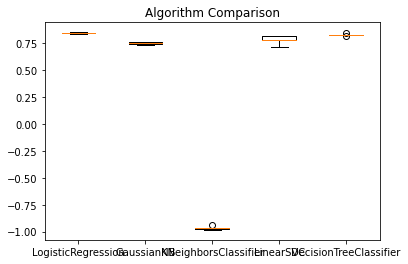

In [19]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

KNN is the best identified model from the lot.

## Finding the best model

Minimum error:- 0.48970713897304435 at K = 3


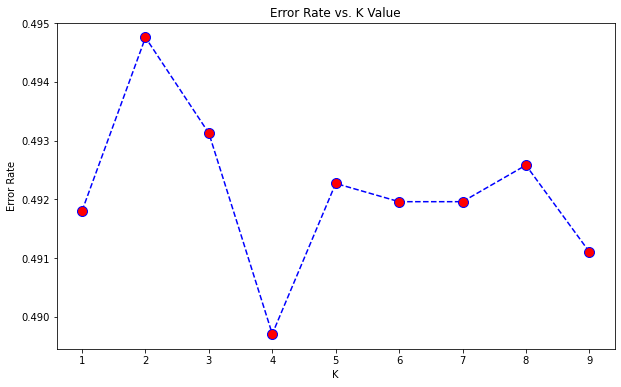

In [20]:
error_rate = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', 
     marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

Text(0.5, 1.0, 'KNN')

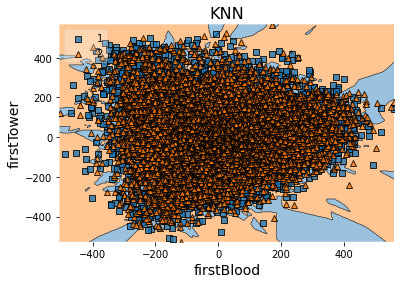

In [21]:
clf = KNeighborsClassifier(n_neighbors=4)
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(X_train)
clf.fit(X_train2, y_train)
plot_decision_regions(X_train2, y_train.values, clf=clf, legend=2)

plt.xlabel(X_train.columns[0], size=14)
plt.ylabel(X_train.columns[1], size=14)
plt.title('KNN', size=16)

In [22]:
n_feats = X_train_cp.shape[1]
print('Feature  Accuracy')
feature_dict = {}
for i in range(n_feats):
    print("Feature : "+list(X_train_cp.columns)[i])
    X = X_train[[list(X_train_cp.columns)[i]]]
    scores = cross_val_score(clf, X, y_train, cv=3)
    feature_dict[list(X_train_cp.columns)[i]] = scores.mean()

Feature  Accuracy
Feature : firstBlood
Feature : firstTower
Feature : firstInhibitor
Feature : firstBaron
Feature : firstDragon
Feature : firstRiftHerald
Feature : t1_champ1id
Feature : t1_champ1_sum1
Feature : t1_champ1_sum2
Feature : t1_champ2id
Feature : t1_champ2_sum1
Feature : t1_champ2_sum2
Feature : t1_champ3id
Feature : t1_champ3_sum1
Feature : t1_champ3_sum2
Feature : t1_champ4id
Feature : t1_champ4_sum1
Feature : t1_champ4_sum2
Feature : t1_champ5id
Feature : t1_champ5_sum1
Feature : t1_champ5_sum2
Feature : t1_towerKills
Feature : t1_inhibitorKills
Feature : t1_baronKills
Feature : t1_dragonKills
Feature : t1_riftHeraldKills
Feature : t1_ban1
Feature : t1_ban2
Feature : t1_ban3
Feature : t1_ban4
Feature : t1_ban5
Feature : t2_champ1id
Feature : t2_champ1_sum1
Feature : t2_champ1_sum2
Feature : t2_champ2id
Feature : t2_champ2_sum1
Feature : t2_champ2_sum2
Feature : t2_champ3id
Feature : t2_champ3_sum1
Feature : t2_champ3_sum2
Feature : t2_champ4id
Feature : t2_champ4_sum1
Fea

In [23]:
feature_dict

{'firstBlood': 0.501747872488466,
 'firstTower': 0.5023434322469268,
 'firstInhibitor': 0.7435128956817724,
 'firstBaron': 0.6334030966347453,
 'firstDragon': 0.5059170804756402,
 'firstRiftHerald': 0.5689738445112731,
 't1_champ1id': 0.5040526005427503,
 't1_champ1_sum1': 0.5021103682320107,
 't1_champ1_sum2': 0.5063573125038151,
 't1_champ2id': 0.505709976835259,
 't1_champ2_sum1': 0.5020326802270386,
 't1_champ2_sum2': 0.5006860881408567,
 't1_champ3id': 0.5048552981396833,
 't1_champ3_sum1': 0.4996243520729056,
 't1_champ3_sum2': 0.5058393884473633,
 't1_champ4id': 0.5080147893789451,
 't1_champ4_sum1': 0.5038972104512393,
 't1_champ4_sum2': 0.5068234405336473,
 't1_champ5id': 0.5052695174903602,
 't1_champ5_sum1': 0.5047258643994024,
 't1_champ5_sum2': 0.506383192412253,
 't1_towerKills': 0.776862902395059,
 't1_inhibitorKills': 0.5924874140161416,
 't1_baronKills': 0.6229929039684929,
 't1_dragonKills': 0.5792235435238141,
 't1_riftHeraldKills': 0.5059947684806123,
 't1_ban1': 0.

In [24]:
recommendation_order = sorted(feature_dict.items(), key=lambda x: x[1])[::-1]
print(recommendation_order)

[('t2_towerKills', 0.8272554313046365), ('t1_towerKills', 0.776862902395059), ('t2_inhibitorKills', 0.7636332400522057), ('firstInhibitor', 0.7435128956817724), ('t2_baronKills', 0.6410683111136667), ('firstBaron', 0.6334030966347453), ('t1_baronKills', 0.6229929039684929), ('t2_dragonKills', 0.6152498988903258), ('t1_inhibitorKills', 0.5924874140161416), ('t1_dragonKills', 0.5792235435238141), ('t2_riftHeraldKills', 0.5689738445112731), ('firstRiftHerald', 0.5689738445112731), ('t1_champ4id', 0.5080147893789451), ('t2_champ3_sum2', 0.5070047326617729), ('t1_champ4_sum2', 0.5068234405336473), ('t1_champ5_sum2', 0.506383192412253), ('t1_champ1_sum2', 0.5063573125038151), ('t2_champ2id', 0.5063572783057239), ('t2_champ4_sum1', 0.5062537284971858), ('t2_ban5', 0.5060465061693115), ('t1_riftHeraldKills', 0.5059947684806123), ('firstDragon', 0.5059170804756402), ('t1_champ3_sum2', 0.5058393884473633), ('t1_champ2id', 0.505709976835259), ('t2_champ4_sum2', 0.5052955704009067), ('t1_champ5id'

In [25]:
unique_actions = []
for x in recommendation_order:
    if x[0][x[0].find("_")+1:] not in unique_actions and "champ" not in x[0]:
        unique_actions.append(x[0][x[0].find("_")+1:])
print(unique_actions)

['towerKills', 'inhibitorKills', 'firstInhibitor', 'baronKills', 'firstBaron', 'dragonKills', 'riftHeraldKills', 'firstRiftHerald', 'ban5', 'firstDragon', 'ban1', 'ban3', 'ban4', 'firstTower', 'firstBlood', 'ban2']


The recommendation system works by suggesting the following actions in the follwoing order shown above. The probability of winning increases as the actions are completed one after the other. Following this order, the player will have the highest probability of winning a game.

## Improvements in the study

The model cannot be used in realtime right now because the game is very competetive and constantly updating from time to time. Although we have a blueprint from the model output winning cannot be guaranteed 100% of the time. The prediction can be improved in such a way that every action taen by the player, A suggestion on what exactlyto do nextis suggested. This way the output is constantly adopting to new scenarios in the game.

## Alternative Solutions

Models such as ALS(Alternating Least Squares), EM(Expectation Maximization) and SVD which make predictions based on user interactions with the options rather than previous actions might perform better as the game updates or even when new additions are made to the game.